In [1]:
import argparse
import os
import sys

# Libs and helpers
import numpy as np

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
from IPython.display import display, Latex, Math

2022-03-08 12:59:00.852330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 12:59:00.852369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [3]:
def printSignal(exper: Experiment, qubits: List[chip.Qubit],
                gate: gates.Instruction, output: DataOutput):
    signals = exper.pmap.generator.generate_signals(gate)
    for i, qubit in enumerate(qubits):
        # generate signal
        drive = getDrive(exper.pmap.model, qubit).name
        signal = signals[drive]
        ts = signal["ts"].numpy()
        values = signal["values"].numpy()

        # save data
        peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
        print("peaks: ", np.sort(peakFrequencies))
        output.save([ts, values], f"signal_t{i + 1}")

        # plot
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_t{i + 1}", "png"))
        #plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_{i+1}", "png"), spectralThreshold=5e-4)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    print(gate.get_key())
    populations = calculatePopulation(exper, init, [gate.get_key()])
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population"))
    plotSplittedPopulation(exper, populations, [gate.get_key()], filename=output.createFileName("population"))


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    #plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name), colourMap='hsv')
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
    #                            filename=output.createFileName(name + "_phase"))
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
    #                            filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")
    printMatrix(U, labels, "propagator", output)


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]
    for name, values in outputs.items():
        filename = output.createFileName(directory + "/device_" + name, "svg")
        time = values["ts"].numpy()
        if name.startswith("LO"):
            #time = time[:100]
            re = values["inphase"].numpy()
            im = values["quadrature"].numpy()
            plotSignalAndSpectrum(time, real=re, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_real", "svg"))
            plotSignalAndSpectrum(time, real=im, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_imag", "svg"))
        elif "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=5e-4)
        else:
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=5e-4, filename=filename)


def optimise(output: DataOutput, qubits: List[chip.PhysicalComponent],
             exp: Experiment, algorithm, options, gate: gates.Instruction):
    # set up the optimiser
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_set,
        fid_subspace=[q.name for q in qubits],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=gate.name,
        fid_func_kwargs={
            "active_levels": 4
        }
    )
    exp.set_opt_gates([gate.get_key()])
    opt.set_exp(exp)

    # add the callback
    infidelities = []

    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)

    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities

In [4]:
output = DataOutput(output_dir, file_suffix='before')

qubit_levels = [2, 2]
#level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"] #, "leakage"]
#level_labels = []
#level_labels_with_leakage = []
#for i in range(qubit_levels[0]):
#    for j in range(qubit_levels[1]):
#        if i > (qubit_levels[0] - 1) or j > (qubit_levels[1] - 1):
#            level_labels_with_leakage.append("leakage")
#        else:
#            s = f"${level_labels_transmon[i]}\otimes{level_labels_transmon[j]}$"
#            level_labels.append(s)
#            level_labels_with_leakage.append(s)
#level_labels_transmon = [f"${x}$" for x in level_labels_transmon]
level_labels = ["0", "1", "2", "3"]

def getEnergies(couplingStrength: float) -> np.array:
    # Initialise the qubits and drive lines
    qubit_frequencies = [5e9, 4.5e9]
    anharmonicities = [-300e6, -250e6]
    t1s = [25e-6, 25e-6]
    t2stars = [35e-6, 35e-6]
    qubit_temps = [50e-3, 50e-3]

    qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                          t2stars, qubit_temps)
    coupling = createChainCouplings([couplingStrength], qubits)
    #drives = createDrives(qubits)

    # Create the model
    model = Mdl(qubits, coupling) # + drives)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)

    #energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
    #print("energies: ", energies)
    qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
    qubitEnergies[0] = qubitEnergies[0][::qubit_levels[0]]
    qubitEnergies[1] = qubitEnergies[1][:qubit_levels[1]]
    qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
    #for i in range(len(qubits)):
    #    print(f"Qubit {i}:")
    #    print(qubitEnergies[i])
    #    print(qubitTransitions[i])
    #Hpartial = partialTrace(model.get_Hamiltonian().numpy(), [0,1])
    #return Hpartial.diagonal().real / (2 * np.pi)
    H = model.get_Hamiltonian().numpy()  #.diagonal().real / (2 * np.pi)
    return np.linalg.eigvals(H).real / (2 * np.pi)

0 0.0
1 668896.3210702341
2 1337792.6421404681
3 2006688.9632107022
4 2675585.2842809362
5 3344481.6053511705
6 4013377.9264214044
7 4682274.247491638
8 5351170.5685618725
9 6020066.889632107


2022-03-08 12:59:14.753513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 12:59:14.753589: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 12:59:14.753651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist


10 6688963.210702341
11 7357859.531772574
12 8026755.852842809
13 8695652.173913043
14 9364548.494983276
15 10033444.816053512
16 10702341.137123745
17 11371237.458193978
18 12040133.779264214
19 12709030.100334447
20 13377926.421404682
21 14046822.742474915
22 14715719.063545149
23 15384615.384615384
24 16053511.705685617
25 16722408.02675585
26 17391304.347826086
27 18060200.66889632
28 18729096.989966553
29 19397993.311036788
30 20066889.632107023
31 20735785.953177255
32 21404682.27424749
33 22073578.595317725
34 22742474.916387957
35 23411371.23745819
36 24080267.558528427
37 24749163.87959866
38 25418060.200668894
39 26086956.52173913
40 26755852.842809364
41 27424749.163879596
42 28093645.48494983
43 28762541.806020066
44 29431438.127090298
45 30100334.448160533
46 30769230.769230768
47 31438127.090301
48 32107023.411371235
49 32775919.73244147
50 33444816.0535117
51 34113712.37458194
52 34782608.69565217
53 35451505.0167224
54 36120401.33779264
55 36789297.658862874
56 37458193

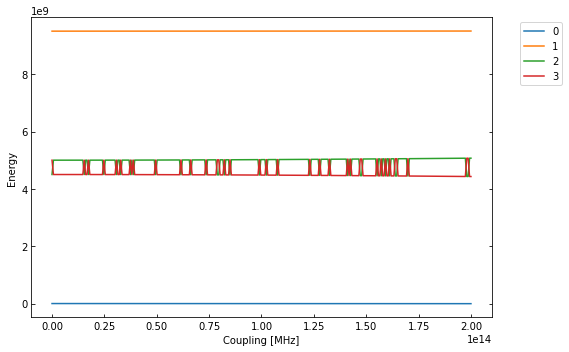

In [5]:
N = 300
numLevels = np.prod(qubit_levels)
gs = np.linspace(0, 200e6, N)
allEnergies = np.empty((numLevels, 0))

for i,g in enumerate(gs):
    print(i, g)
    energies = getEnergies(g).reshape((numLevels, 1))
    allEnergies = np.append(allEnergies, energies, axis=1)

fig, axs = plt.subplots(1, 1, figsize=[8, 5])
axs.plot(gs / 1e-6, allEnergies.T)
axs.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
axs.set_xlabel("Coupling [MHz]")
axs.set_ylabel("Energy")
plt.legend(level_labels, ncol=1, bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()